In [1]:
import sys
sys.path.append("d:\\SMU\\ml&applns")

import pandas as pd
import numpy as np
import tensorflow as tf
import time
from Preprocessing.DFTransformations import *
from Preprocessing.DataExtration import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from random import randint

from os import listdir
from os.path import isfile, join

Based on Global Data:

min_frame = 1

max_frames = 414

mean_frames = 64.7...

median_frames = 41

std = 56.7579
_______________________________
Frame_Target = 65

In [2]:
def calc_stats_types(pf):
    grouped_data = pf.groupby('frame')[['x','y','z']]
    grouped_data = np.array([group.values for _, group in grouped_data])
    arr = np.transpose(grouped_data, (0, 2, 1))

    face_data = arr[:, :, :7]
    left_hand_data = arr[:, :, 7:24]
    pose_data = arr[:, :, 24:30]
    right_hand_data = arr[:, :, 30:]

    data = [left_hand_data, pose_data, right_hand_data]

    video_data = calculate_stats_np(face_data)

    for a in data:
        video_data = np.concatenate((video_data, calculate_stats_np(a)), axis=1)

    video_data = np.nan_to_num(video_data, 0)

    return video_data

In [4]:
import warnings

# Initialize a list of folder names containing parquet files
folders = ["hello", "all", "thankyou", "for", "time", "will", "now", "please", "quiet", "down", "listen", "close", "have", "no", "nap", "bye", "base", "good", "how", "show", "we", "work"]
optional = ["if", "noisy", "mad", "sad"]

folders = np.append(folders, optional)

# Initialize lists for aggregated data and labels
aggregated_files = []
labels = []

## ------------------------ To Tune ------------------------ ##
# Transform data in pf to accommodate the desired frame amount
# If less than frame num, duplicate frames or pad with 0's
# If more than frame num, delete frames
frames_target = 65
duplicate = True
remove_points = True
# Set duplicate to True if you want to duplicate frames to reach
#   target frame amount.
# Else, set to False to pad the data with 0's
## --------------------------------------------------------- ##

# Iterate over the folders in the list
for folder in folders:
    # Update path to focus on content inside folder in the current iteration
    path = "../asl-kaggle/averaged_by_labels/"+folder+"/"

    # Fetch all file names in the folder
    parquets = [f for f in listdir(path) if isfile(join(path, f))]

    # Iterate over file names in the list (up to the 50th file name)
    for parquet in parquets[:]:
        # Update path to focus on the file in the current iteration
        parquet_path = path + parquet
        
        # Read the file at the path and load data to pf
        pf = pd.read_parquet(parquet_path)
        
        # Remove all rows with the type of face
        pf = pf.drop(pf.loc[pf.type=="face"].index)
        
        # Replace all NaN values with 0
        pf = pf.fillna(0)

        if len(pf.frame.unique()) < 10:
            continue
        
        pf = transform_data(pf, frames_target, duplicate, remove_points) # (int)
        # pf = pf.drop(['row_id','type','landmark_index'], axis=1)

        pf = pf.sort_values('type')

        if remove_points:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                video_data = calc_stats_types(pf)
        else:
            video_data = calculate_stats(pf)

        if not duplicate:
            frame_num = video_data.shape[0]
            if frame_num != frames_target:
                pad = np.zeros(shape=((frames_target - frame_num), video_data.shape[1]))
                video_data = np.concatenate((video_data, pad), axis=0)

        labels.append(folder)

        # Append array to list
        aggregated_files.append(video_data)

In [5]:
try:
    dataset = np.array(aggregated_files)
except:
    print("Padding Data")

    # Find the maximum length of arrays
    max_length = max(arr.shape[0] for arr in aggregated_files)

    # Pad each array along the first dimension (rows)
    padded_data = [np.pad(arr, ((0, max_length - arr.shape[0]), (0, 0), (0, 0), (0, 0)), mode='constant') for arr in aggregated_files]

    # Convert the list of padded arrays back to a numpy array
    dataset = np.array(padded_data)

dataset.shape

(7627, 65, 120)

In [6]:
def random_scaling(array, scaling_factor=0.01):
    scaling_factors = np.random.uniform(low=1-scaling_factor, high=1+scaling_factor, size=array.shape[0])
    scaling_factors = scaling_factors[:, np.newaxis, np.newaxis]
    return array * scaling_factor

def augment_data(data, labels, perc_augment=0.1):
    noisy_data = random_scaling(data, 0.03)
    
    amt = int(len(data)*perc_augment)-1
    amt = 1 if amt <= 0 else amt

    noisy_data, _, noisy_labels, _ = train_test_split(noisy_data, labels, train_size=amt, shuffle=True)

    data = np.concatenate([data, noisy_data])
    labels = np.concatenate([labels, noisy_labels])

    return data, labels

In [7]:
from sklearn.preprocessing import StandardScaler

encoder = LabelBinarizer().fit(labels)
y = encoder.transform(labels)

# dataset, y = augment_data(dataset, y, perc_augment=0.3)

# X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(dataset, y, test_size=0.2, random_state=21)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

# X_tr, X_test, y_tr, y_test = train_test_split(dataset, y, test_size=0.1, shuffle=True)

In [ ]:
# X_train, y_train = X_tr, y_tr
# X_val, y_val = X_v, y_v

# X_train, y_train = augment_data(X_tr, y_tr, 0.3)
# X_val, y_val = augment_data(X_v, y_v, 0.01)

# X_train, y_train = augment_data(X_tr, y_tr, 0.3)
# X_train, y_train = augment_data(X_train, y_train, 1)
# X_train, y_train = augment_data(X_train, y_train, 1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Standardize the features while retaining 3D shape
scaler = StandardScaler()

X_train_std = X_train.reshape(X_train.shape[0], -1)  # Flatten to 2D
X_train_std = scaler.fit_transform(X_train_std)
X_train = X_train_std.reshape(X_train.shape)  # Reshape back to 3D

X_val_std = X_val.reshape(X_val.shape[0], -1)  # Flatten to 2D
X_val_std = scaler.transform(X_val_std)
X_val = X_val_std.reshape(X_val.shape)

# X_test_std = X_test.reshape(X_test.shape[0], -1)  # Flatten to 2D
# X_test_std = scaler.transform(X_test_std)
# X_test = X_test_std.reshape(X_test.shape)

In [14]:
X_train.shape

(6101, 65, 120)

In [15]:
X_val.shape

(1526, 65, 120)

In [13]:
import pickle

with open('label_binarizer.pkl', 'wb') as f:
    pickle.dump(encoder, f)
    
with open('standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [9]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, AveragePooling1D, BatchNormalization, Input, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import DepthwiseConv1D, SeparableConv1D, LocallyConnected1D
from tensorflow.keras.layers import SpatialDropout1D, GaussianDropout, AlphaDropout
from tensorflow.keras import Sequential


In [ ]:
## --------------------------------------------------------------------------------------------------------------##

# TODO
#   You can select from any of these belo layers and implement into the below model:
#   -Conv1D     -MaxPooling1D   -AveragePooling1D   -Dropout    -BatchNormalization
#   
#   You can change GlobalAveragePooling1D to GlobalMaxPooling1D
#
#   For Conv1D you can change/set the following parameters:
#   - filters (i.e. neurons)
#   - kernel_size
#   - strides
#   - activation (Refer to: https://www.tensorflow.org/api_docs/python/tf/keras/activations)
#   - kernel_regularizer (regularization techniques, refer to: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers)
#
#   For Pooling Layers:
#   - pool_size : This parameter effectively divides the data dimensions by the provided integer value
#

## --------------------------------------------------------------------------------------------------------------##

model = Sequential()

model.add(Input((X_train.shape[1], X_train.shape[2])))

model.add(Conv1D(32, kernel_size=4, activation='relu'))
model.add(Conv1D(32, kernel_size=4, activation='relu'))
model.add(AveragePooling1D(pool_size=2))

model.add(AlphaDropout(0.4))

model.add(Conv1D(16, kernel_size=2, activation='relu'))
model.add(AveragePooling1D(pool_size=2))

model.add(AlphaDropout(0.4))

model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(AveragePooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(AlphaDropout(0.3))

model.add(Conv1D(128, kernel_size=2, activation='relu'))
model.add(Conv1D(128, kernel_size=2, activation='relu'))
model.add(AveragePooling1D(pool_size=2))

model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.8))

model.add(Dense(y.shape[1], activation='softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(0.015)))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [10]:
model = Sequential()
model.add(Input((X_train.shape[1], X_train.shape[2])))

model.add(Conv1D(64, kernel_size=2, activation='selu'))
model.add(Conv1D(64, kernel_size=2, activation='selu'))
model.add(MaxPooling1D(pool_size=2))

model.add(AlphaDropout(0.3))
model.add(BatchNormalization())

model.add(Conv1D(64, kernel_size=4, activation='selu'))
model.add(Conv1D(64, kernel_size=4, activation='selu'))
model.add(AveragePooling1D(pool_size=3))

model.add(AlphaDropout(0.4))
model.add(BatchNormalization())

model.add(Conv1D(128, kernel_size=2, activation='selu'))
model.add(Conv1D(128, kernel_size=2, activation='selu'))
model.add(Conv1D(128, kernel_size=2, activation='selu'))
model.add(MaxPooling1D(pool_size=2))

model.add(GlobalAveragePooling1D())
model.add(Dropout(0.8))

model.add(Dense(y.shape[1], activation='softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(0.005)))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64, 64)            15424     
                                                                 
 conv1d_1 (Conv1D)           (None, 63, 64)            8256      
                                                                 
 max_pooling1d (MaxPooling1  (None, 31, 64)            0         
 D)                                                              
                                                                 
 alpha_dropout (AlphaDropou  (None, 31, 64)            0         
 t)                                                              
                                                                 
 batch_normalization (Batch  (None, 31, 64)            256       
 Normalization)                                                  
                                                     

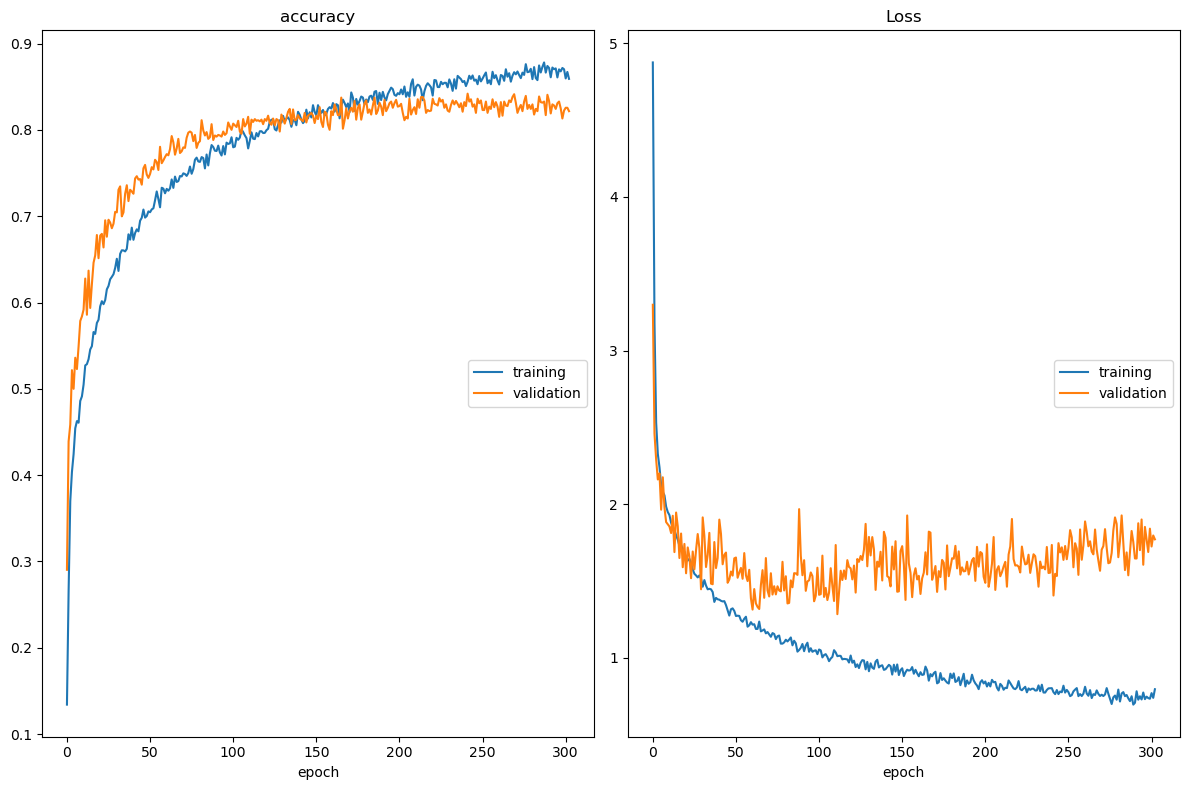

accuracy
	training         	 (min:    0.134, max:    0.878, cur:    0.859)
	validation       	 (min:    0.290, max:    0.842, cur:    0.822)
Loss
	training         	 (min:    0.696, max:    4.874, cur:    0.797)
	validation       	 (min:    1.285, max:    3.298, cur:    1.772)


KeyboardInterrupt: 

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

# Train the model
batch_size = 16
epochs = 500

# Set up early stopping callback

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, callbacks=[PlotLossesKeras()], verbose=0)
# model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])

In [25]:
import sys
sys.path.append("d:\\SMU\\ml&applns")

from Preprocessing.Video_Preprocessing import VideoPreprocessing
from Preprocessing.DFTransformations import *
from Preprocessing.DataExtration import *
from Preprocessing.Average_parquet import Averager
from sklearn.preprocessing import LabelBinarizer, StandardScaler

import pandas as pd
import numpy as np
import warnings
import pickle

class Pipeline():

    def __init__(self, path_to_video) -> None:
        self.frames_target = 65
        self.duplicate = True
        self.remove_points = True

        with open('../Preprocessing/standard_scaler.pkl', 'rb') as f:
            self.scaler = pickle.load(f)

        data = VideoPreprocessing().process_video(path_to_video)
        self.data = Averager(data).average_pf()
        pass

    def process_input(self) -> np.ndarray:
        self.data_restructuring()
        self.data_statistics()
        return self.data

    def data_restructuring(self) -> None:
        video_data = self.data

        # Remove all rows with the type of face
        video_data = video_data.drop(video_data.loc[video_data.type=="face"].index)

        # Replace all NaN values with 0
        video_data = video_data.fillna(0)

        video_data = transform_data(video_data, self.frames_target, self.duplicate, self.remove_points)
        self.data = video_data

    def data_statistics(self) -> None:
        video_data = self.data

        video_data = video_data.sort_values('type')

        if self.remove_points:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                video_data = calc_stats_types(video_data)
        else:
            video_data = calculate_stats(video_data)

        if not self.duplicate:
            frame_num = video_data.shape[0]
            if frame_num != self.frames_target:
                pad = np.zeros(shape=((self.frames_target - frame_num), video_data.shape[1]))
                video_data = np.concatenate((video_data, pad), axis=0)

        video_data = np.array(video_data)
        video_data = np.reshape(video_data, (1, 65, 120))
        
        # Scaling the data
        video_data_std = video_data.reshape(video_data.shape[0], -1)
        video_data_std = self.scaler.fit_transform(video_data_std)
        video_data = video_data_std.reshape(video_data.shape)

        self.data = video_data

In [27]:
import cv2
import os
import numpy as np
import mediapipe as mp
import pandas as pd
from Preprocessing.mp_support import mediapipe_detection, draw_landmarks, draw_styled_landmarks, extract_keypoints, extract_coordinates, prob_viz

class VideoPreprocessing():

    def __init__(self) -> None:
        self.savepath = "../Pipeline/video"
        self.clean_folder()
        pass

    def clean_folder(self) -> None:
        # Get a list of all files in the folder
        files = os.listdir(self.savepath)

        # Iterate over the files and remove each one
        for file in files:
            file_path = os.path.join(self.savepath, file)
            os.remove(file_path)

    def process_video(self, video_path) -> pd.DataFrame:
        self.extract_frames_data(video_path)
        return self.convert_to_df()

    def extract_frames_data(self, path) -> None:
        extract_coordinates(path, self.savepath)

    def convert_to_df(self) -> pd.DataFrame:

        # create empty data frame
        df = pd.DataFrame(columns=['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z'])
        
        frame_counter = 1 
        
        # for video
        for frame in os.listdir(self.savepath):
            
            frame_path = os.path.join(self.savepath, frame)
            
            with open(frame_path, 'rb') as file:
                npy_data = np.load(file)
            
                # scan through npy file and add data to df in batches of 3
                local_count = 1
                for j in range(0, 99, 3):
                    new_row = pd.Series({'frame': frame_counter, 'row_id': f"{frame_counter}-pose-{local_count}", 'type': 'pose', 'landmark_index': local_count, 'x': npy_data[j], 'y': npy_data[j+1], 'z': npy_data[j+2]})
                    
                    df = pd.concat([df, new_row.to_frame().T], ignore_index = True, axis = 0)
                    
                    local_count += 1
                
                local_count = 1
                for j in range(99, 162, 3):
                    new_row = pd.Series({'frame': frame_counter, 'row_id': f"{frame_counter}-left_hand-{local_count}", 'type': 'left_hand', 'landmark_index': local_count, 'x': npy_data[j], 'y': npy_data[j+1], 'z': npy_data[j+2]})
                    
                    df = pd.concat([df, new_row.to_frame().T], ignore_index = True, axis = 0)
                    
                    local_count += 1
                
                local_count = 1
                for j in range(162, 225, 3):
                    new_row = pd.Series({'frame': frame_counter, 'row_id': f"{frame_counter}-right_hand-{local_count}", 'type': 'right_hand', 'landmark_index': local_count, 'x': npy_data[j], 'y': npy_data[j+1], 'z': npy_data[j+2]})
                    
                    df = pd.concat([df, new_row.to_frame().T], ignore_index = True, axis = 0)
                    
                    local_count += 1
                
            frame_counter += 1
        
        return df

In [39]:
folders = ["Good","Show","We","Work"]
predictions = []
labels = []

for folder in folders:
    for i in range(5):
        path_to_video = f"../{folder}/{folder}{i+1}.mp4"
        label = folder

        test = Pipeline(path_to_video).process_input()
        prediction = model.predict(test)
        prediction = encoder.inverse_transform(prediction)

        predictions.append(prediction)
        labels.append(label)


1/1 [==============================] - 0s 16ms/step


In [41]:
np.concatenate(predictions)

array(['bye', 'bye', 'bye', 'bye', 'bye', 'bye', 'bye', 'bye', 'bye',
       'bye', 'bye', 'bye', 'bye', 'bye', 'bye', 'bye', 'bye', 'bye',
       'bye', 'bye'], dtype='<U8')

In [38]:
path_to_video = "../We/We3.mp4"
label = "show/"

test = Pipeline(path_to_video).process_input()
prediction = model.predict(test)
print(encoder.inverse_transform(prediction))
print(label)

1/1 [==============================] - 0s 33ms/step
['bye']
show/


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val, batch_size=batch_size)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, batch_size=batch_size)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

In [ ]:
x_all = np.concatenate([X_train, X_val])
y_all = np.concatenate([y_train, y_val])

In [ ]:
loss, accuracy = model.evaluate(x_all, y_all, batch_size=batch_size)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')